<a href="https://colab.research.google.com/github/FR-Schwartz/IDS705_Team10/blob/main/10_code/auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a final Auto Encoder file.

In [1]:
# Check if GPU is enabled on Google Colab
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [12]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
from tensorflow import keras 
from tensorflow.keras.utils import to_categorical
from google.colab import drive
import os
import pickle
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import TensorBoard


In [13]:
# Copy drive to colab
drive.mount('/content/MyDrive/')
os.chdir('/content/MyDrive/MyDrive/IDS705_Final') #change to file path on your disk

Mounted at /content/MyDrive/


In [14]:
#Helper Functions
def parse_tfrecord(example):
  """
  This function helps in parsing tfrecord files when creating a TF Dataset object
  """
  feature = {'image': tf.io.FixedLenFeature([240, 240, 155, 4], tf.float32),
             'label': tf.io.FixedLenFeature([240, 240, 155], tf.int64)}
  parsed_example = tf.io.parse_single_example(example, feature)
  return parsed_example

def get_image_and_label(features):
  """
  Extract Image and Label Object from tfrecord files
  """
  image, label = features['image'], features['label']
  return image, label

def get_image_and_label_auto(features):
  """
  Extract Image and Label Object from tfrecord files
  """
  image = features['image']
  return image, image

def get_dataset(tfrecord_names):
  """
  Create TF dataset files that can be fed into model functions
  """
  dataset = (tf.data.TFRecordDataset(tfrecord_names)
             .map(parse_tfrecord)
             .map(get_image_and_label_auto))

  return dataset

In [15]:
def encoder(input_layer):
  # Elements in layer represent in this order batchSize, height, width, channels
  print("*****Encoder*****", input_layer)

  x4 = tf.keras.layers.BatchNormalization()(input_layer)
  x4 = tf.keras.layers.Conv3D( 4, 3, strides=(1,1,1), activation='relu', padding='same')(x4)
  x4 = tf.keras.layers.BatchNormalization()(x4)
  x4 = tf.keras.layers.Conv3D( 4, 3, strides=(1,1,1), activation='relu', padding='same')(x4)
  x4 = tf.keras.layers.BatchNormalization()(x4)

  print("x1", x4.shape)

  x8 = tf.keras.layers.Conv3D( 8, 3, strides=(2,2,2), activation='relu', padding='same')(x4)
  x8 = tf.keras.layers.BatchNormalization()(x8)
  x8 = tf.keras.layers.Conv3D( 8, 3, strides=(1,1,1), activation='relu', padding='same')(x8)
  x8 = tf.keras.layers.BatchNormalization()(x8)

  print("x2", x8.shape)

  x16 = tf.keras.layers.Conv3D(16, 3, strides=(2,2,2), activation='relu', padding='same')(x8)
  x16 = tf.keras.layers.BatchNormalization()(x16)
  x16 = tf.keras.layers.Conv3D(16, 3, strides=(1,1,1), activation='relu', padding='same')(x16)
  x16 = tf.keras.layers.BatchNormalization()(x16)

  print("x3", x16.shape)

  x32 = tf.keras.layers.Conv3D(32, 3, strides=(2,2,2), activation='relu', padding='same')(x16)
  x32 = tf.keras.layers.BatchNormalization()(x32)
  x32 = tf.keras.layers.Conv3D(32, 3, strides=(1,1,1), activation='relu', padding='same')(x32)
  x32 = tf.keras.layers.BatchNormalization()(x32)

  print("x4", x32.shape)

  x64 = tf.keras.layers.Conv3D(64, 3, strides=(2,2,2), activation='relu', padding='same')(x32)
  x64 = tf.keras.layers.BatchNormalization()(x64)
  x64 = tf.keras.layers.Conv3D(64, 3, strides=(1,1,1), activation='relu', padding='same')(x64)
  x64 = tf.keras.layers.BatchNormalization()(x64)
  
  print("x5", x64.shape)

  x128 = tf.keras.layers.Conv3D(128, 3, strides=(2,2,2), activation='relu', padding='same')(x64)
  x128 = tf.keras.layers.BatchNormalization()(x128)
  x128 = tf.keras.layers.Conv3D(128, 3, strides=(1,1,1), activation='relu', padding='same')(x128)
  x128 = tf.keras.layers.BatchNormalization()(x128)

  print("x6", x128.shape)

  return x128


In [16]:
def decoder(encoded_layer):
  print("*****Decoder*****", encoded_layer)

  x64 = tf.keras.layers.Conv3DTranspose(64, 3, strides=(1,1,1), activation='relu')(encoded_layer)
  x64 = tf.keras.layers.Conv3DTranspose(64, 3, strides=(2,2,2), activation='relu', padding='same')(x64)
  x64 = tf.keras.layers.Cropping3D(cropping=((1,2), (1,2), (1,1)))(x64)
  x64 = tf.keras.layers.Cropping3D(cropping=((1,1), (1,1), (1,1)))(x64)
  print("x1", x64.shape)

  
  x32 = tf.keras.layers.Conv3DTranspose(32, 3, strides=(1,1,1), activation='relu')(x64)
  x32 = tf.keras.layers.Conv3DTranspose(32, 3, strides=(2,2,2), activation='relu', padding='same')(x32)
  x32 = tf.keras.layers.Cropping3D(cropping=((1,1), (1,1), (1,1)))(x32)
  x32 = tf.keras.layers.Cropping3D(cropping=((1,1), (1,1), (1,1)))(x32)

  print("x2", x32.shape)

  x16 = tf.keras.layers.Conv3DTranspose(16, 3, strides=(1,1,1), activation='relu')(x32)
  x16 = tf.keras.layers.Conv3DTranspose(16, 3, strides=(2,2,2), activation='relu', padding='same')(x16)
  x16 = tf.keras.layers.Cropping3D(cropping=((1,1), (1,1), (1,1)))(x16)
  x16 = tf.keras.layers.Cropping3D(cropping=((1,1), (1,1), (1,2)))(x16)

  print("x4", x16.shape)

  x8 = tf.keras.layers.Conv3DTranspose(8, 3, strides=(1,1,1), activation='relu')(x16)
  x8 = tf.keras.layers.Conv3DTranspose(8, 3, strides=(2,2,2), activation='relu', padding='same')(x8)
  x8 = tf.keras.layers.Cropping3D(cropping=((1,1), (1,1), (1,1)))(x8)
  x8 = tf.keras.layers.Cropping3D(cropping=((1,1), (1,1), (1,1)))(x8)

  print("x5", x8.shape)

  x4 = tf.keras.layers.Conv3DTranspose(4, 3, strides=(1,1,1), activation='relu')(x8)
  x4 = tf.keras.layers.Conv3DTranspose(4, 3, strides=(2,2,2), activation='relu', padding='same')(x4)
  x4 = tf.keras.layers.Cropping3D(cropping=((1,1), (1,1), (1,1)))(x4)
  x4 = tf.keras.layers.Cropping3D(cropping=((1,1), (1,1), (1,2)))(x4)

  print("x6", x4.shape)

  return x4
  


In [17]:
# Combine Encoder and Deocder layers
from tensorflow.keras.models import Model

input_layer = tf.keras.layers.Input(shape=(240,240,155,4))
e_l = encoder(input_layer)
output = decoder(e_l)

autoencoder = Model(inputs = input_layer, outputs = output)

*****Encoder***** KerasTensor(type_spec=TensorSpec(shape=(None, 240, 240, 155, 4), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
x1 (None, 240, 240, 155, 4)
x2 (None, 120, 120, 78, 8)
x3 (None, 60, 60, 39, 16)
x4 (None, 30, 30, 20, 32)
x5 (None, 15, 15, 10, 64)
x6 (None, 8, 8, 5, 128)
*****Decoder***** KerasTensor(type_spec=TensorSpec(shape=(None, 8, 8, 5, 128), dtype=tf.float32, name=None), name='batch_normalization_12/FusedBatchNormV3:0', description="created by layer 'batch_normalization_12'")
x1 (None, 15, 15, 10, 64)
x2 (None, 30, 30, 20, 32)
x4 (None, 60, 60, 39, 16)
x5 (None, 120, 120, 78, 8)
x6 (None, 240, 240, 155, 4)


In [23]:
from tensorflow.keras import backend as k

class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):

        inter = k.sum(y_true[:,:,-1]*y_pred[:,:,-1])
        return (2*inter + 1)/(k.sum(y_true[:,:,-1]) + k.sum(y_pred[:,:,-1]) + 1)

In [24]:
lr=1e-3
autoencoder.compile(loss=DiceLoss(), optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 155, 4  0         
                             )]                                  
                                                                 
 batch_normalization (BatchN  (None, 240, 240, 155, 4)  16       
 ormalization)                                                   
                                                                 
 conv3d (Conv3D)             (None, 240, 240, 155, 4)  436       
                                                                 
 batch_normalization_1 (Batc  (None, 240, 240, 155, 4)  16       
 hNormalization)                                                 
                                                                 
 conv3d_1 (Conv3D)           (None, 240, 240, 155, 4)  436       
                                                             

In [19]:
#Create Train / Val / Test Split
subfolders = os.listdir("/content/MyDrive/MyDrive/IDS705_Final/Data/Train")
np.random.seed(101)
split = np.random.choice(["Train","Val","Test"], len(subfolders), p=[0.6, 0.2, 0.2])
train_ids = [subfolders[i] for i,v in enumerate(split) if v=="Train"]
val_ids = [subfolders[i] for i,v in enumerate(split) if v=="Val"]
test_ids = [subfolders[i] for i,v in enumerate(split) if v=="Test"]

In [20]:
#Create dataset objects
train_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in train_ids])
test_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in test_ids])
val_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in val_ids])
mini_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in subfolders[100:228]])
minival_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in subfolders[500:508]])

In [21]:
batchsize = 4
shufflesize = 8
mini_dataset_trainable = mini_dataset.shuffle(shufflesize).batch(batchsize)
minival_dataset_validable = minival_dataset.batch(batchsize)
train_dataset_trainable = train_dataset.shuffle(shufflesize).batch(batchsize)
val_dataset_validable = val_dataset.batch(batchsize)

In [46]:
# Train Autoencoder
epochs = 5
auto_enc = autoencoder.fit(mini_dataset_trainable, epochs = epochs, verbose=1, validation_data=minival_dataset_validable, batch_size = 4, shuffle = False, callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])


Epoch 1/5
32/32 [==============================] - 141s 4s/step - loss: 3.3476e-07 - val_loss: 3.0865e-07
Epoch 2/5
32/32 [==============================] - 125s 4s/step - loss: 2.8810e-07 - val_loss: 2.6772e-07
Epoch 3/5
32/32 [==============================] - 125s 4s/step - loss: 2.5140e-07 - val_loss: 2.3514e-07
Epoch 4/5
32/32 [==============================] - 125s 4s/step - loss: 2.2198e-07 - val_loss: 2.0882e-07
Epoch 5/5
32/32 [==============================] - 184s 6s/step - loss: 1.9806e-07 - val_loss: 1.8726e-07


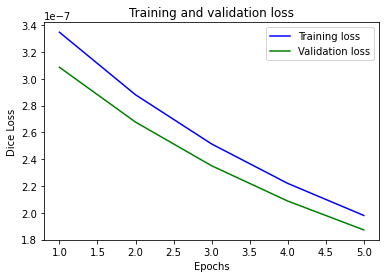

In [52]:
# Plot loss curves
loss = auto_enc.history['loss']
val_loss = auto_enc.history['val_loss']
epochs = [1,2,3,4,5]

plt.figure()
plt.plot(epochs, loss, 'b', linestyle="-", label='Training loss')
plt.plot(epochs, val_loss, 'g', linestyle="-", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel("Dice Loss")
plt.legend()
plt.show()
plt.close()